## Setup

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from td.client import TDClient
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
# from code.functions import *
%matplotlib inline

In [3]:
pd.set_option('display.max_columns',None)

In [4]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [5]:
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [6]:
# sns.pairplot(df)

In [7]:
df.isna().sum()

age        0
edu        0
hus_edu    0
chil       0
rel        0
work       0
hus_ocu    0
sol        0
media      0
cmc        0
dtype: int64

In [8]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

Questions:  
ad spending or government spending on health education, to better target demographics who are not likely to use short or long-term contraceptive methods  
each row represents a person  
target variable is contraceptive method

# EDA

In [11]:
X = df.copy()
y = X.pop('cmc')

In [12]:
def feature_plot(df, ind, dep, plot_type, xlabel, xlog = 'n', ylog = 'n', color = u'#1f77b4'):
    ylabel = f'Contraception Method'
    title = f'{ylabel} vs {xlabel}'
    file_name = f'{xlabel}.png'
    fig, ax = plt.subplots(figsize = [12,8])
    if plot_type == 'scatter':
        sns_obj = sns.scatterplot(data = df, x=ind, y=dep, ax=ax, color = color)
    elif plot_type == 'line':
        sns_obj = sns.lineplot(data = df, x=ind, y=dep, color = color)
    if xlog == 'y':
        set_x_log(sns_obj, ax)
    if ylog == 'y':
        set_y_log(sns_obj, ax)
    # what color is u'#1f77b4'? what color is None?
    ax.set_title(title, fontdict = {'fontsize': 14})
    ax.set_xlabel(xlabel, fontdict = {'fontsize': 12})
    ax.set_ylabel(ylabel, fontdict = {'fontsize': 12})
    plt.savefig(f'visualizations/{file_name}')

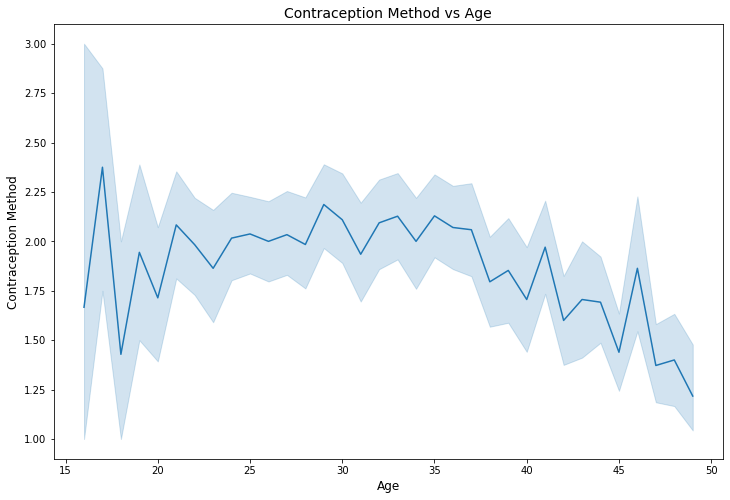

In [13]:
feature_plot(df, df.age, y, 'line', 'Age', xlog = 'n', ylog = 'n', color = u'#1f77b4')

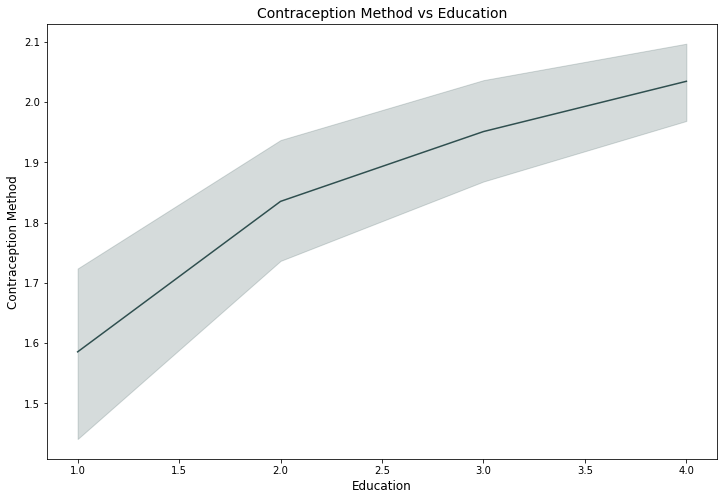

In [14]:
feature_plot(df, df.edu, y, 'line', 'Education', color = 'darkslategray')

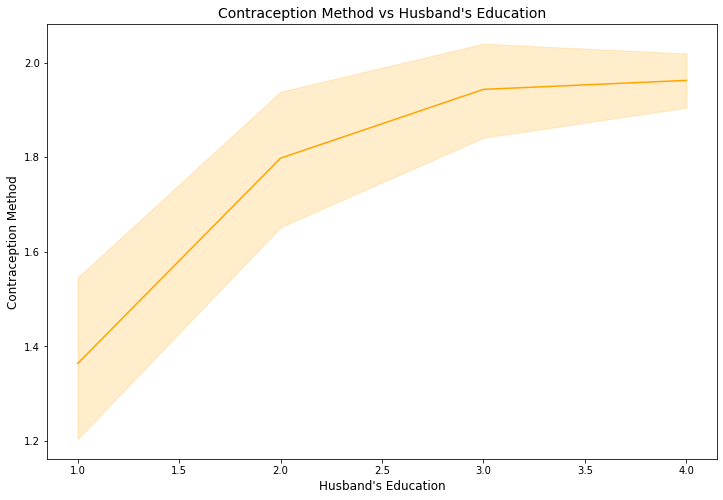

In [15]:
feature_plot(df, df.hus_edu, y, 'line', 'Husband\'s Education', color = 'orange')

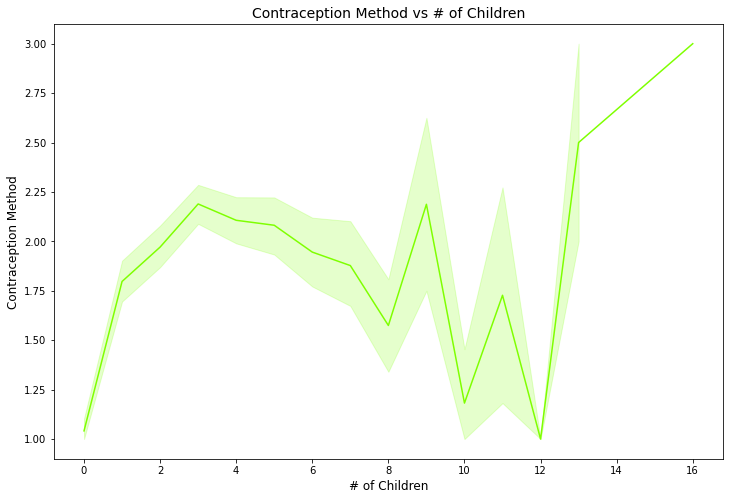

In [16]:
feature_plot(df, df.chil, y, 'line', '# of Children', color = 'chartreuse')

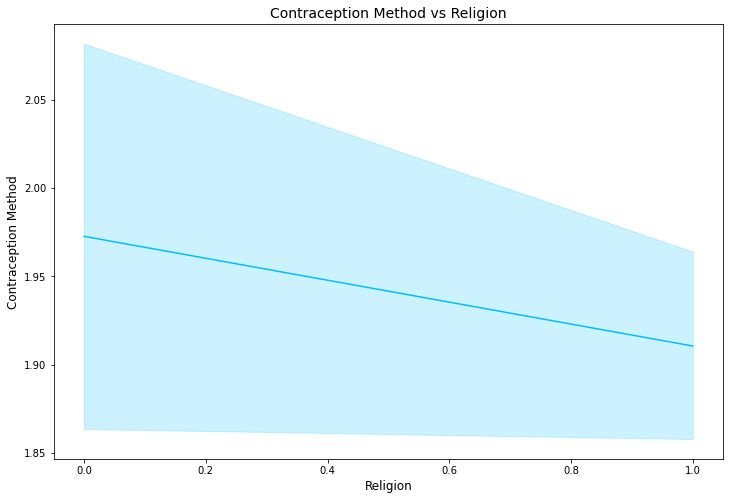

In [17]:
feature_plot(df, df.rel, y, 'line', 'Religion', color = 'deepskyblue')

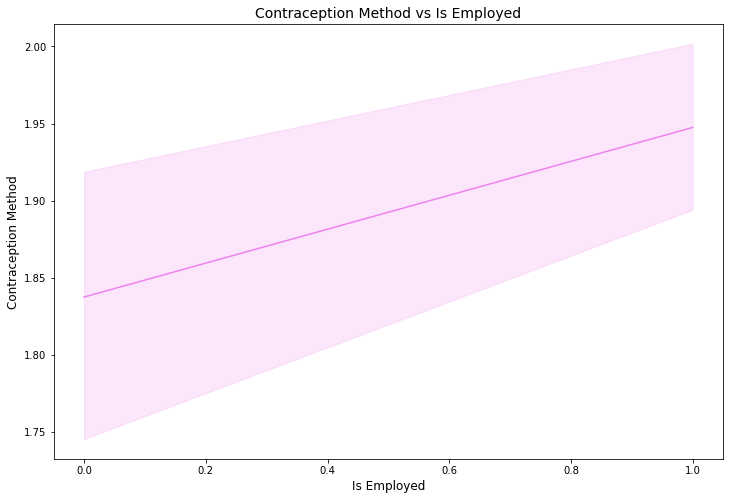

In [18]:
feature_plot(df, df.work, y, 'line', 'Is Employed', color = 'violet')

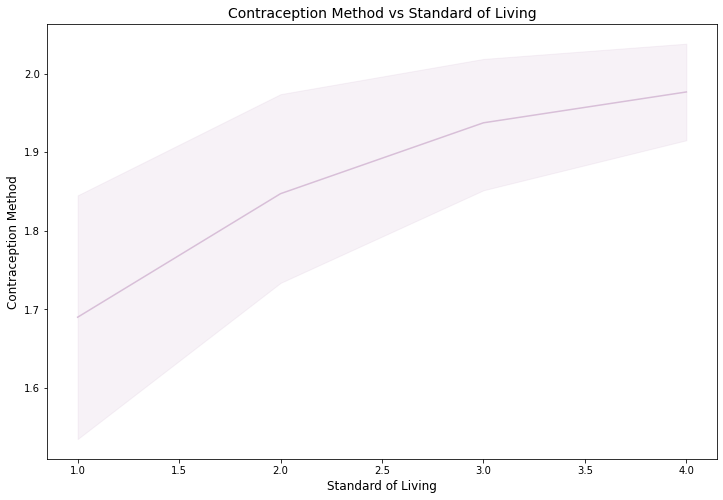

In [19]:
feature_plot(df, df.sol, y, 'line', 'Standard of Living', color = 'thistle')

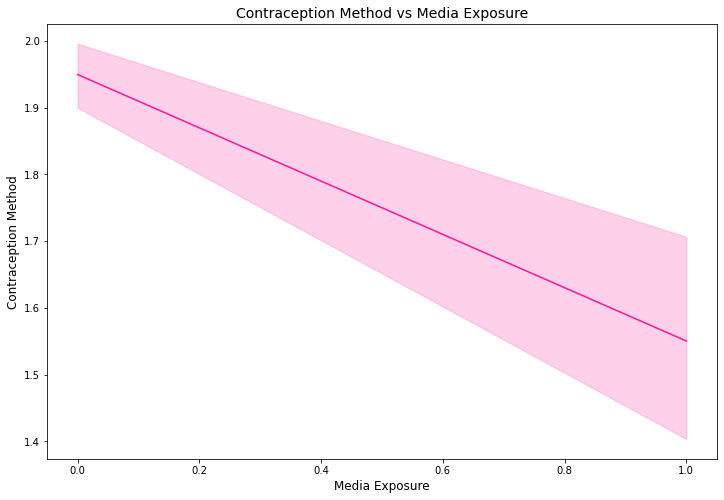

In [20]:
feature_plot(df, df.media, y, 'line', 'Media Exposure', color = 'deeppink')

In [21]:
# find menopause data for 1987

In [22]:
# hist, box, violin, bar
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


# Feature Engineering

## Dumying

In [23]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums = pd.get_dummies(df, columns=to_dummy)
X_with_dums.shape

(1473, 30)

## Split data into train and test sets

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
X_train.shape

(1104, 30)

## Scale features

In [25]:
rs = RobustScaler()

rs.fit(X_train)
X_train = rs.transform(X_train)
X_test = rs.transform(X_test)

In [27]:
# keep age continuous
# create new variable 18 or younger

# Modeling

## Functions

In [30]:
def grid_search(model_type, X, y):
    if model_type == log:
        model = LogisticRegression()
        params_grid = {
            'multi_class': 'multinomial',
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-4, 4, 20),
            'l1_ratio': stats.expon(scale=0.2),
        }
    elif model_type == dtc:
        model = DecisionTreeClassifier()
        params_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 3, 2],
            'min_samples_split': [2, 10, 20]
        }
    elif model_type == knn:
        model = KNeighborsClassifier()

    gridsearch_model = GridSearchCV(estimator=model_type, param_grid=params_grid)

    gridsearch_model.fit(X_train, y_train)
    print(gridsearch_model.best_params_)
    best_model = gridsearch_model.best_estimator_
    best_model.score(X_test, y_test)

In [31]:
def log_reg(X_train, X_test, y_train, y_test):
    # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=.25,
#         random_state=1)
    
    # Scale the data for modeling
#     log_scaler = StandardScaler()
#     log_scaler.fit(X_train)
#     X_train_sc = log_scaler.transform(X_train)
#     X_test_sc = log_scaler.transform(X_test)
    
    # Train a logistic regression model with the train data
    log_model = LogisticRegression(multi_class='multinomial', max_iter=1000
#                                    solver='lbfgs'
#                                    solver='liblinear',
#                                    C=.001,
#                                    class_weight = 'balanced'
                                  )
    log_model.fit(X_train, y_train)
#     y_pred = log_model.predict(X_test)
#     y_prob = log_model.predict_proba(X_test)
    model_stats(X.columns, log_model, X_test, y_test)
    return log_model

In [33]:
def model_stats(features, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    print('Num features: ', features.size)
    print('Model score: ', model.score(X_test, y_test))
    print('Model F1 (micro): ', f1_score(y_test, y_pred, average='micro'))
    print('Model F1 (macro): ', f1_score(y_test, y_pred, average='macro'))
    print('Model F1 (weighted): ', f1_score(y_test, y_pred, average='weighted'))
    print('Cross validation score: ', cross_val_score(model, X_test, y_test, cv=5) )
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    fig, ax = plt.subplots(figsize = [6,8])
    plot_confusion_matrix(model, X_test, y_test, ax = ax)
#     plot_roc_curve(model, X_test_sc, y_test, ax = ax[1])
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Logistic Regression - Base Model

Num features:  12
Model score:  0.5718157181571816
Model F1 (micro):  0.5718157181571816
Model F1 (macro):  0.5405777690559126
Model F1 (weighted):  0.5660858901627333
Cross validation score:  [0.60810811 0.52702703 0.58108108 0.48648649 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68       161
           2       0.59      0.33      0.43        87
           3       0.46      0.59      0.52       121

    accuracy                           0.57       369
   macro avg       0.57      0.54      0.54       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.753431 (macro),
0.756977 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.758908 (macro),
0.760028 (weighted by prevalence)


LogisticRegression(max_iter=1000, multi_class='multinomial')

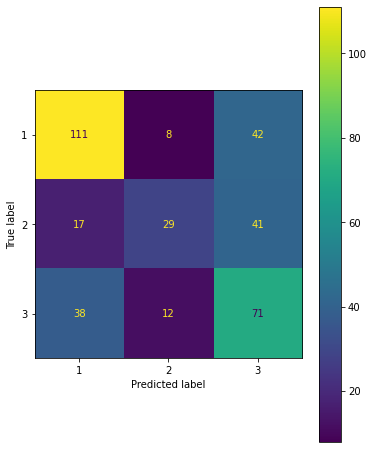

In [48]:
log_reg(X_train, X_test, y_train, y_test)

## Pipeline

### LogisticRegression GridSearchCV

In [71]:
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression())])

params_grid_lr = {'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear', 'saga'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

{'lr': LogisticRegression(C=11.288378916846883, class_weight='balanced', dual=True,
                   l1_ratio=1.623776739188721, solver='liblinear'), 'lr__C': 11.288378916846883, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 1.623776739188721, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Num features:  12
Model score:  0.5799457994579946
Model F1 (micro):  0.5799457994579946
Model F1 (macro):  0.5633474866720004
Model F1 (weighted):  0.5839297056676974
Cross validation score:  [0.56756757 0.5        0.54054054 0.55405405 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.72      0.63      0.68       161
           2       0.46      0.48      0.47        87
           3       0.51      0.58      0.54       121

    accuracy                           0.58       369
   macro avg       0.57      0.56      0.56       369
weighted avg       0.59      0.58      0.58       369

One-vs-One ROC AUC scores:
0.754

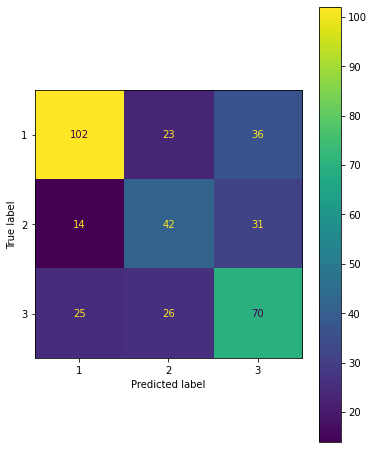

In [35]:
clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
clf.fit(X_train, y_train)
print(clf.best_params_)
best_clf = clf.best_estimator_
model_stats(X.columns, best_clf, X_test, y_test)

### RandomForestClassifier GridSearchCV

{'rfc': RandomForestClassifier(max_depth=9, n_estimators=60), 'rfc__max_depth': 9, 'rfc__max_features': 'auto', 'rfc__n_estimators': 60}
Num features:  12
Model score:  0.5501355013550135
Model F1 (micro):  0.5501355013550135
Model F1 (macro):  0.5131772942097367
Model F1 (weighted):  0.5384219035518075
Cross validation score:  [0.56756757 0.41891892 0.54054054 0.43243243 0.43835616]
Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.73      0.66       161
           2       0.56      0.32      0.41        87
           3       0.47      0.48      0.47       121

    accuracy                           0.55       369
   macro avg       0.54      0.51      0.51       369
weighted avg       0.55      0.55      0.54       369

One-vs-One ROC AUC scores:
0.710307 (macro),
0.712379 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.712481 (macro),
0.714414 (weighted by prevalence)


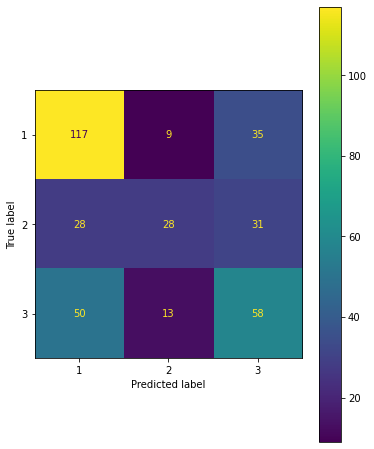

In [43]:
pipe_rfc = Pipeline([('rfc' , RandomForestClassifier())])

params_grid_rfc = {'rfc' : [RandomForestClassifier()],
                   'rfc__n_estimators' : list(range(10,101,10)),
                   'rfc__max_features': ['auto', 'sqrt', 'log2'],
                   'rfc__max_depth' : list(range(1,10))
                  }

clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.best_params_)
best_clf = clf.best_estimator_
model_stats(X.columns, best_clf, X_test, y_test)

### With Tomek Link resampling --> LogisticRegression

In [39]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train.ravel()
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 367, 3: 290, 2: 246})


{'lr': LogisticRegression(C=29.763514416313132, class_weight='balanced', dual=True,
                   l1_ratio=0.0018329807108324356, solver='liblinear'), 'lr__C': 29.763514416313132, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0018329807108324356, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Num features:  12
Model score:  0.5420054200542005
Model F1 (micro):  0.5420054200542005
Model F1 (macro):  0.5369583040314015
Model F1 (weighted):  0.5493034113570716
Cross validation score:  [0.58108108 0.52702703 0.55405405 0.54054054 0.50684932]
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.50      0.60       161
           2       0.43      0.55      0.48        87
           3       0.47      0.59      0.52       121

    accuracy                           0.54       369
   macro avg       0.55      0.55      0.54       369
weighted avg       0.59      0.54      0.55       369

One-vs-One ROC AUC score

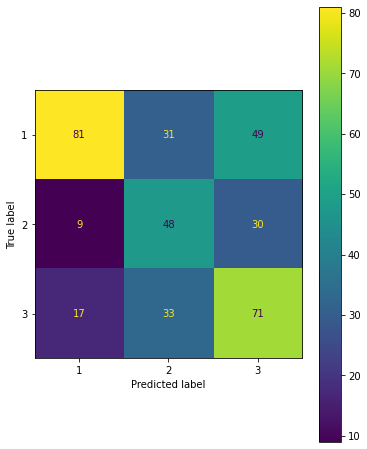

In [72]:
# Create grid search object
clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
clf.fit(X_res, y_res)
print(clf.best_params_)
best_clf = clf.best_estimator_
model_stats(X.columns, best_clf, X_test, y_test)

### With Tomek Link resampling --> RandomForestClassifier

{'rfc': RandomForestClassifier(max_depth=9, n_estimators=50), 'rfc__max_depth': 9, 'rfc__max_features': 'auto', 'rfc__n_estimators': 50}
Num features:  12
Model score:  0.5447154471544715
Model F1 (micro):  0.5447154471544715
Model F1 (macro):  0.5352095876752699
Model F1 (weighted):  0.5459873558563796
Cross validation score:  [0.55405405 0.41891892 0.54054054 0.45945946 0.47945205]
Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.59      0.61       161
           2       0.48      0.53      0.50        87
           3       0.50      0.50      0.50       121

    accuracy                           0.54       369
   macro avg       0.53      0.54      0.54       369
weighted avg       0.55      0.54      0.55       369

One-vs-One ROC AUC scores:
0.721029 (macro),
0.719891 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.718641 (macro),
0.716159 (weighted by prevalence)


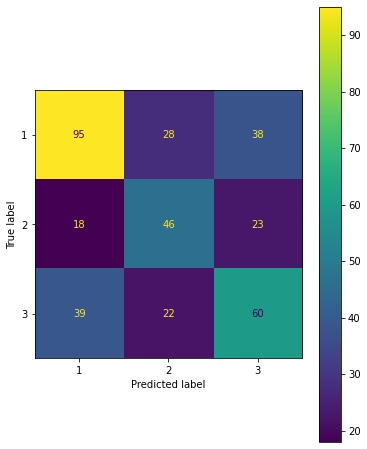

In [66]:
# Create grid search object
clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
clf.fit(X_res, y_res)
print(clf.best_params_)
best_clf = clf.best_estimator_
model_stats(X.columns, best_clf, X_test, y_test)

### XGBoost with GridSearchCV

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729))])
params_grid_xgb = {'xgb__nthread': [4],  # when use hyperthread, xgboost may become slower
                   'xgb__objective': ['binary:logistic', 'reg:squarederror'],
                   'xgb__learning_rate': np.linspace(0.01, 0.2, 20),
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__max_depth': [4, 5, 6, 7, 8, 9, 10],
                   'xgb__min_child_weight': [7,9,11,13,15],
                   'xgb__subsample': [0.2, 0.4, 0.6, 0.8],
                   'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9],
                   'xgb__n_estimators': [5, 10, 20, 50, 100, 250, 1000],
                   'xgb__missing': [-999]
                  }
clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=5, shuffle=True), 
                  scoring='roc_auc',
                  verbose=2, refit=True)
clf.fit(X_train, y_train)
print(clf.best_params_)
best_clf = clf.best_estimator_
model_stats(X.columns, best_clf, X_test, y_test)

Fitting 5 folds for each of 588000 candidates, totalling 2940000 fits
